/Users/sarayabesi/Documents/research-poly/eye-tracker-project/machine_learning/dataset_1
Logistic Regression - Cross-Validation ROC-AUC Scores: [0.665625   0.88235294 0.76315789 0.69736842 0.78947368]
Logistic Regression - Mean ROC-AUC Score: 0.759595588235294
Logistic Regression - Test Set Performance:
Accuracy: 0.8444444444444444
Precision: 0.8
Recall: 0.9090909090909091
F1-Score: 0.8510638297872342
ROC-AUC: 0.8320158102766798


Random Forest - Cross-Validation ROC-AUC Scores: [0.725      0.83281734 0.71546053 0.60361842 0.95230263]
Random Forest - Mean ROC-AUC Score: 0.7658397832817336
Random Forest - Test Set Performance:
Accuracy: 0.8
Precision: 0.782608695652174
Recall: 0.8181818181818182
F1-Score: 0.8
ROC-AUC: 0.8478260869565217


Gradient Boosting - Cross-Validation ROC-AUC Scores: [0.65625    0.85139319 0.69078947 0.50328947 0.86513158]
Gradient Boosting - Mean ROC-AUC Score: 0.7133707430340557
Gradient Boosting - Test Set Performance:
Accuracy: 0.7111111111111111
Precision: 0

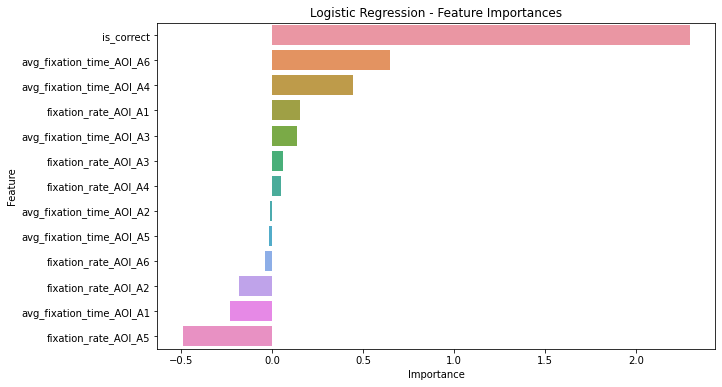

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os 

# Get the current working directory
main_dir = os.getcwd()
print(main_dir)

# Load your dataset
file_path = os.path.join(main_dir, "dataset_1.csv")
df = pd.read_csv(file_path)

# Features and target
features = ['fixation_rate_AOI_A1', 'fixation_rate_AOI_A2', 'fixation_rate_AOI_A3', 'fixation_rate_AOI_A4',
             'fixation_rate_AOI_A5', 'fixation_rate_AOI_A6', 'avg_fixation_time_AOI_A1', 'avg_fixation_time_AOI_A2',
             'avg_fixation_time_AOI_A3', 'avg_fixation_time_AOI_A4', 'avg_fixation_time_AOI_A5', 'avg_fixation_time_AOI_A6',
             'is_correct']
X = df[features]
y = df['is_accepted']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate the 'is_correct' column
X_train_features = X_train.drop(columns=['is_correct'])
X_test_features = X_test.drop(columns=['is_correct'])
X_train_is_correct = X_train[['is_correct']]
X_test_is_correct = X_test[['is_correct']]

# Preprocessing
# I applied StandardScaler on fixation rate and time to make them have a normal distribition
# I excluded is_correct column from this prepocessin, since it is categorical data and it is not necessary.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Recombine scaled features with the 'is_correct' column
import numpy as np
X_train_scaled = np.hstack([X_train_scaled, X_train_is_correct])
X_test_scaled = np.hstack([X_test_scaled, X_test_is_correct])

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True, kernel='linear')  # using linear kernel for feature importance
}

# Function to get feature importances
def get_feature_importances(model, model_name, feature_names):
    if model_name == 'Logistic Regression' or (model_name == 'SVM' and model.kernel == 'linear'):
        # Coefficients as feature importances for linear models
        importances = model.coef_[0]
    elif model_name in ['Random Forest', 'Gradient Boosting']:
        # Feature importances for tree-based models
        importances = model.feature_importances_
    else:
        return None
    
    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    return feature_importances.sort_values(by='Importance', ascending=False)

# Train and evaluate models with 5-fold cross-validation
feature_names = list(X.columns)
best_accuracy = 0
best_model = None
best_model_name = ""

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f"{name} - Cross-Validation ROC-AUC Scores: {cv_scores}")
    print(f"{name} - Mean ROC-AUC Score: {cv_scores.mean()}")

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Test Set Performance:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1-Score: {f1_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1])}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name
    
    print("\n")

# Get feature importances for the best model
if best_model is not None:
    print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy}")
    feature_importances = get_feature_importances(best_model, best_model_name, feature_names)
    if feature_importances is not None:
        print(f"{best_model_name} - Feature Importances:")
        print(feature_importances)
        
        # Plotting feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importances)
        plt.title(f'{best_model_name} - Feature Importances')
        plt.show()
